In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

from analysis import start_jvm, functional_connectivity, global_signal_regression, artifact_filter

Load data

In [3]:
BOT = 'bot_04'

# Load  bot images
img_before = cv2.cvtColor(cv2.imread(f'bot_images/{BOT}_before_00001.tiff'), cv2.COLOR_BGR2GRAY)
img_after = cv2.cvtColor(cv2.imread(f'bot_images/{BOT}_after_00001.tiff'), cv2.COLOR_BGR2GRAY)

# Load spatial data
pixel_df_before = pd.read_csv('spatial_data/raw_spatial/{}_before_pixels.csv'.format(BOT), header=0)
pixel_df_after = pd.read_csv('spatial_data/raw_spatial/{}_after_pixels.csv'.format(BOT), header=0)

com_df_before = pd.read_csv('spatial_data/raw_spatial/{}_before_centroids.csv'.format(BOT), header=0)
com_df_after = pd.read_csv('spatial_data/raw_spatial/{}_after_centroids.csv'.format(BOT), header=0)

# Load raw signals
series_raw_before = np.loadtxt('network_inference_data/series_raw/{}_before_series.csv'.format(BOT), delimiter=',')
series_raw_after = np.loadtxt('network_inference_data/series_raw/{}_after_series.csv'.format(BOT), delimiter=',')

series_gsrw_before = np.loadtxt('network_inference_data/series_gsr_whitened/{}_before_entrate.csv'.format(BOT), delimiter=',')
series_gsrw_after = np.loadtxt('network_inference_data/series_gsr_whitened/{}_after_entrate.csv'.format(BOT), delimiter=',')

# FC matrices
fc_before = np.loadtxt('network_inference_data/fc_matrices/{}_before_mimat_w.csv'.format(BOT), delimiter=',')
fc_after = np.loadtxt('network_inference_data/fc_matrices/{}_after_mimat_w.csv'.format(BOT), delimiter=',')

Visualize the raw data

In [4]:
print(series_raw_before.shape)

(269, 245)


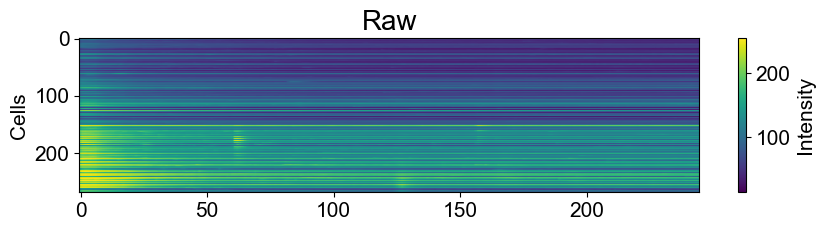

In [5]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_raw_before,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('Raw', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_before_raw.png', dpi=500, bbox_inches='tight', transparent=True)

# ax2 = plt.subplot(gs[1])
# imshow2 = ax2.imshow(series_gsrw_before,aspect='auto')
# plt.colorbar(imshow2, ax=ax2).set_label(label='Intensity',size=15)
# ax2.set_ylabel("Cells", fontsize=15)
# ax2.set_xlabel("Time", fontsize=15)
# ax2.set_title('GSR + whitened')

In [19]:
np.random.seed(10)
before_random_sample = np.random.randint(series_raw_before.shape[0], size=9) # choose 6 random cells ids

In [20]:
before_raw_sample = series_raw_before[before_random_sample,:]

print(before_raw_sample.shape)

(9, 245)


/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/2952128896.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


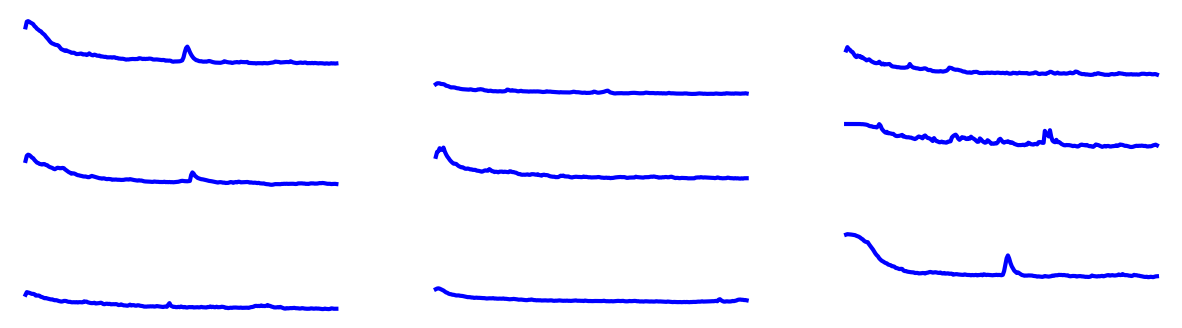

In [34]:
fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)

axes = ax.ravel()


for i in range(len(axes)):

    node_series = before_raw_sample[i,:]

    axes[i].plot(node_series, color='blue', linewidth=3)
    axes[i].axis('off')

plt.savefig('../../Desktop/before_raw_series.png', dpi=500, bbox_inches='tight')
plt.show()

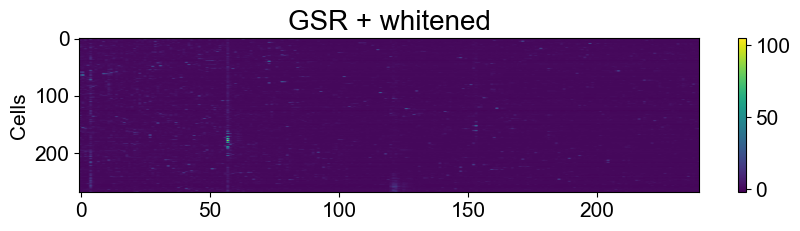

In [7]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_gsrw_before,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
# cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('GSR + whitened', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_before_gsr.png', dpi=500, bbox_inches='tight', transparent=True)

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/3388798465.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


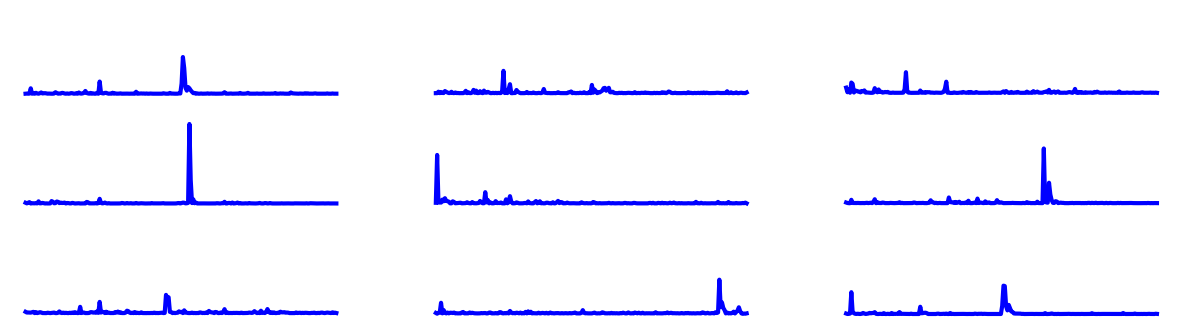

In [37]:
before_gsrw_sample = series_gsrw_before[before_random_sample,:]

fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)
axes = ax.ravel()


for i in range(len(axes)):

    node_series = before_gsrw_sample[i,:]

    axes[i].plot(node_series, color='blue', linewidth=3)
    axes[i].axis('off')

# plt.suptitle('GSR + whitened')
plt.savefig('../../Desktop/before_gsrw_series.png', dpi=500, bbox_inches='tight')
plt.show()


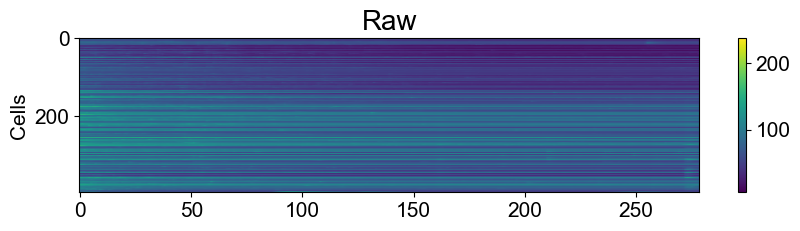

In [8]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_raw_after,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
# cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('Raw', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_after_raw.png', dpi=500, bbox_inches='tight', transparent=True)

In [24]:
np.random.seed(10)
after_random_sample = np.random.randint(series_raw_after.shape[0], size=9) # choose 6 random cells ids

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/83353854.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


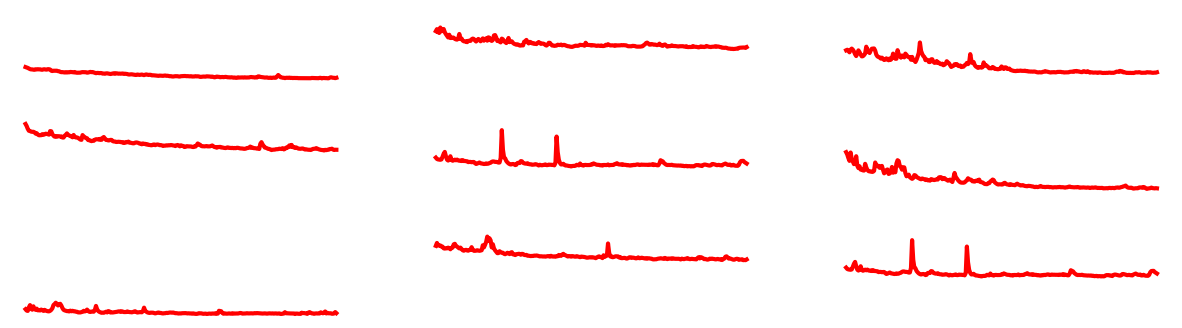

In [38]:
after_raw_sample = series_raw_after[after_random_sample,:]

fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)
axes = ax.ravel()


for i in range(len(axes)):

    node_series = after_raw_sample[i,:]

    axes[i].plot(node_series, color='red', linewidth=3)
    axes[i].axis('off')

plt.savefig('../../Desktop/after_raw_series.png', dpi=500, bbox_inches='tight')
plt.show()


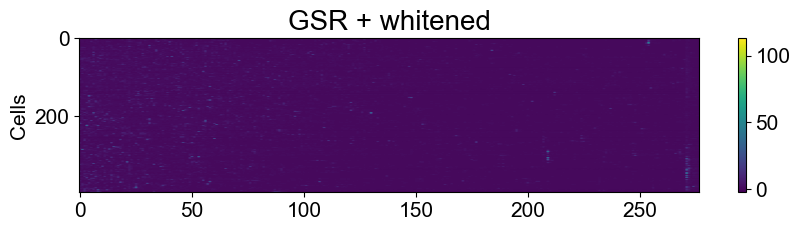

In [9]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_gsrw_after,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
# cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('GSR + whitened', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_after_gsr.png', dpi=500, bbox_inches='tight', transparent=True)

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/2620160699.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


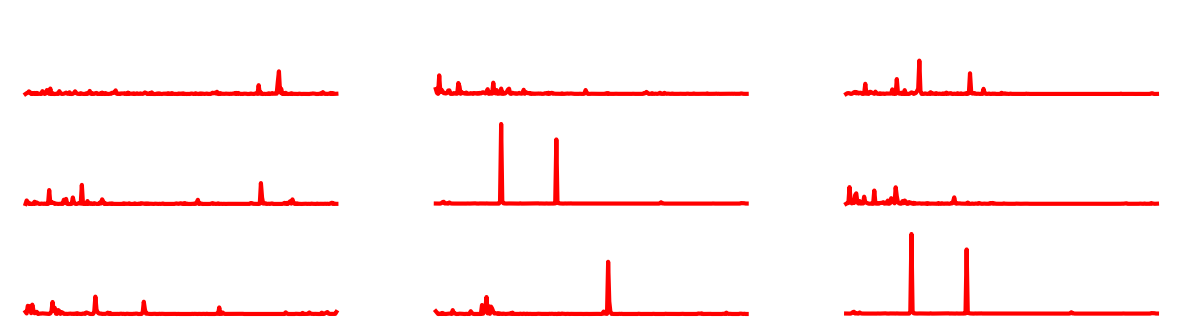

In [39]:
after_gsrw_sample = series_gsrw_after[after_random_sample,:]

fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)
axes = ax.ravel()


for i in range(len(axes)):

    node_series = after_gsrw_sample[i,:]

    axes[i].plot(node_series, color='red', linewidth=3)
    axes[i].axis('off')

plt.savefig('../../Desktop/after_gsrw_series.png', dpi=500, bbox_inches='tight')
plt.show()

STOP

Text(0.5, 0, 'Time')

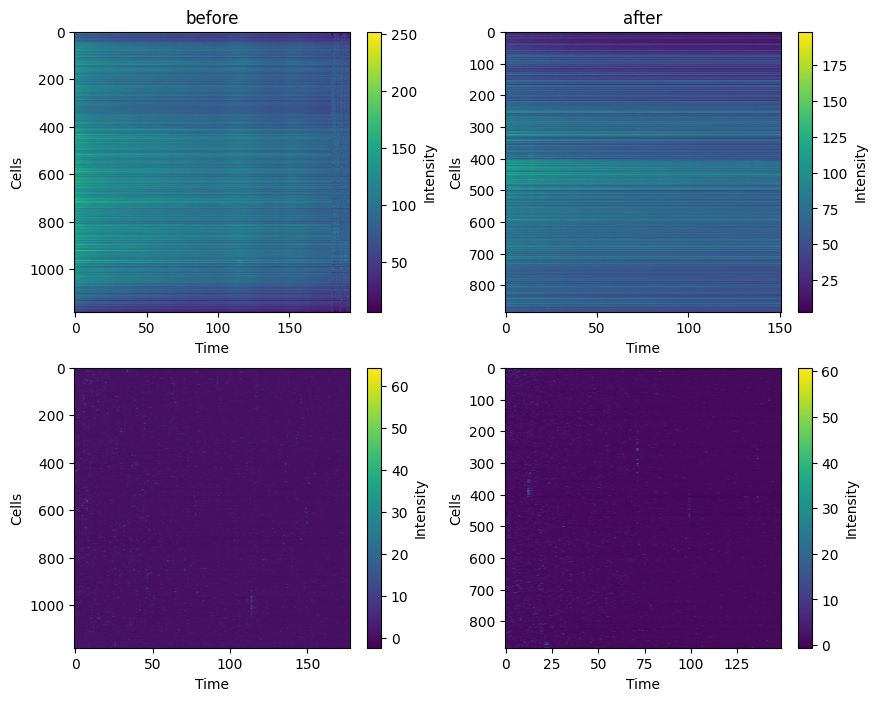

In [4]:
fig = plt.figure(figsize=(10,8))
gs = plt.GridSpec(2, 2, figure=fig, wspace=0.25)

ax1 = plt.subplot(gs[0,0])
imshow1 = ax1.imshow(series_raw_before,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
plt.colorbar(imshow1, ax=ax1, label="Intensity")
ax1.set_ylabel("Cells")
ax1.set_xlabel("Time")
ax1.set_title('before')

ax2 = plt.subplot(gs[0,1])
imshow2 = ax2.imshow(series_raw_after,aspect='auto')
plt.colorbar(imshow2, ax=ax2, label="Intensity")
ax2.set_ylabel("Cells")
ax2.set_xlabel("Time")
ax2.set_title('after')

ax3 = plt.subplot(gs[1,0])
imshow3 = ax3.imshow(series_gsrw_before,aspect='auto')
plt.colorbar(imshow3, ax=ax3, label="Intensity")
ax3.set_ylabel("Cells")
ax3.set_xlabel("Time")

ax4 = plt.subplot(gs[1,1])
imshow4 = ax4.imshow(series_gsrw_after,aspect='auto')
plt.colorbar(imshow4, ax=ax4, label="Intensity")
ax4.set_ylabel("Cells")
ax4.set_xlabel("Time")

### Generate the GSR + unwhitened time series

In [5]:
# ids = df["id"].unique()
# time = df["timestep"].max()

# c = df["value"].values

# series = c.reshape((ids.shape[0], int(c.shape[0]/ids.shape[0])))
# print(series.shape)

series, rejected_frames = artifact_filter(series_raw_before, threshold=5)
print(series.shape)
# np.savetxt(out_dir + "rejected_frames_{0}_{1}.csv".format(bot, scan), rejected_frames, delimiter=",")

N0 = series.shape[0]
N1 = series.shape[1] 

#%%
# Some time series are all one value - this messes things up,
# so we filter out those cells. 
series = series[~np.isclose(series.var(axis=-1), 0),:] 
print(series.shape)
# np.savetxt(out_dir + "series_{0}_{1}_filter.csv".format(bot, scan), series, delimiter=",")

# GSR
# This could also be done w/ local conditional entropies, probably.
# Worth exploring later? 

gsr_before = global_signal_regression(series)
np.savetxt(f"network_inference_data/series_gsr/{BOT}_before_gsr_series.csv", gsr_before, delimiter=",")

(1180, 179)
(1180, 179)


In [6]:
# ids = df["id"].unique()
# time = df["timestep"].max()

# c = df["value"].values

# series = c.reshape((ids.shape[0], int(c.shape[0]/ids.shape[0])))
# print(series.shape)

series, rejected_frames = artifact_filter(series_raw_after, threshold=5)
print(series.shape)
# np.savetxt(out_dir + "rejected_frames_{0}_{1}.csv".format(bot, scan), rejected_frames, delimiter=",")

N0 = series.shape[0]
N1 = series.shape[1] 

#%%
# Some time series are all one value - this messes things up,
# so we filter out those cells. 
series = series[~np.isclose(series.var(axis=-1), 0),:] 
print(series.shape)
# np.savetxt(out_dir + "series_{0}_{1}_filter.csv".format(bot, scan), series, delimiter=",")

# GSR
# This could also be done w/ local conditional entropies, probably.
# Worth exploring later? 

gsr_after = global_signal_regression(series)
np.savetxt(f"network_inference_data/series_gsr/{BOT}_after_gsr_series.csv", gsr_after, delimiter=",")

(884, 150)
(884, 150)


Text(0.5, 0, 'Time')

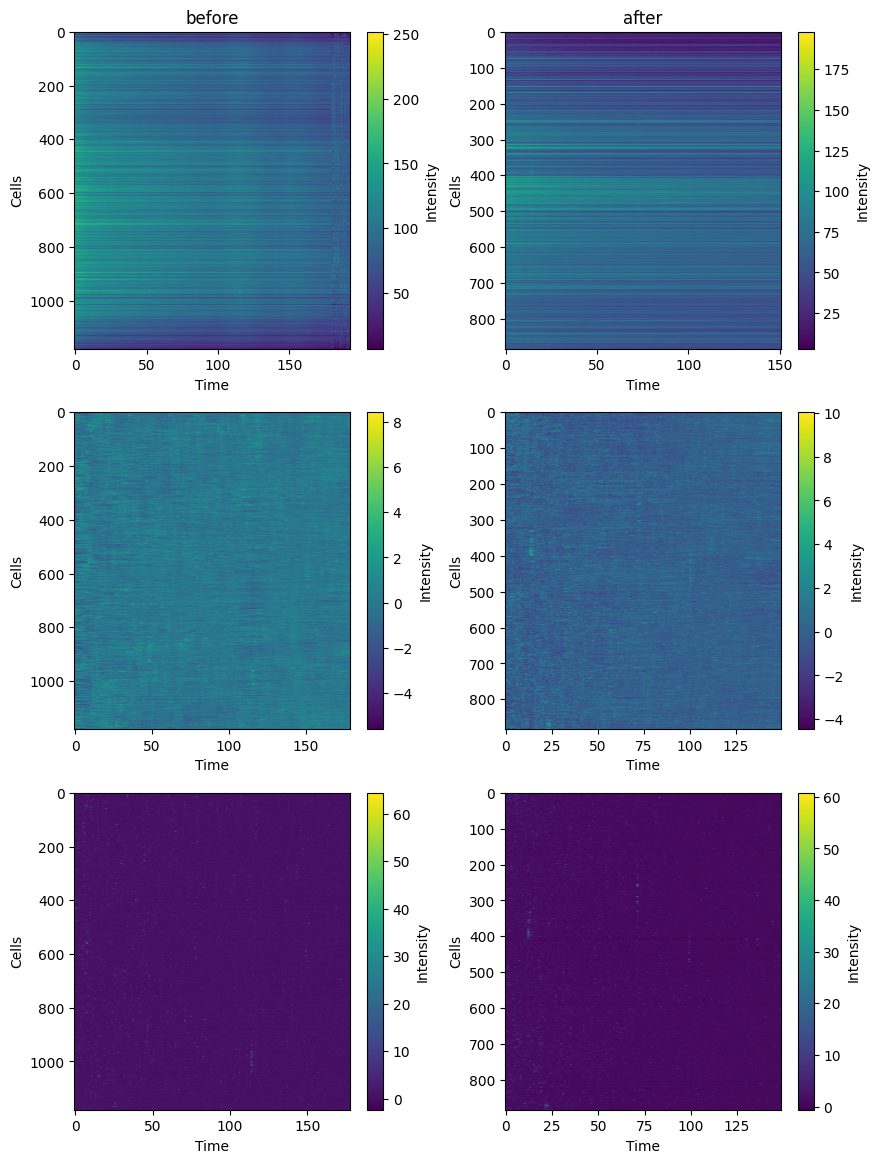

In [7]:
fig = plt.figure(figsize=(10,14))
gs = plt.GridSpec(3, 2, figure=fig, wspace=0.25)

ax1 = plt.subplot(gs[0,0])
imshow1 = ax1.imshow(series_raw_before,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
plt.colorbar(imshow1, ax=ax1, label="Intensity")
ax1.set_ylabel("Cells")
ax1.set_xlabel("Time")
ax1.set_title('before')

ax2 = plt.subplot(gs[0,1])
imshow2 = ax2.imshow(series_raw_after,aspect='auto')
plt.colorbar(imshow2, ax=ax2, label="Intensity")
ax2.set_ylabel("Cells")
ax2.set_xlabel("Time")
ax2.set_title('after')

ax3 = plt.subplot(gs[1,0])
imshow3 = ax3.imshow(gsr_before,aspect='auto')
plt.colorbar(imshow3, ax=ax3, label="Intensity")
ax3.set_ylabel("Cells")
ax3.set_xlabel("Time")

ax4 = plt.subplot(gs[1,1])
imshow4 = ax4.imshow(gsr_after,aspect='auto')
plt.colorbar(imshow4, ax=ax4, label="Intensity")
ax4.set_ylabel("Cells")
ax4.set_xlabel("Time")

ax5 = plt.subplot(gs[2,0])
imshow5 = ax5.imshow(series_gsrw_before,aspect='auto')
plt.colorbar(imshow5, ax=ax5, label="Intensity")
ax5.set_ylabel("Cells")
ax5.set_xlabel("Time")

ax6 = plt.subplot(gs[2,1])
imshow6 = ax6.imshow(series_gsrw_after,aspect='auto')
plt.colorbar(imshow6, ax=ax6, label="Intensity")
ax6.set_ylabel("Cells")
ax6.set_xlabel("Time")

### Remove signal spikes from the gsr + whitened time series 

- replace signals that are outside 2 stds from the mean with that cell's average signal value 

In [14]:
series_gsrw_after_nospikes = series_gsrw_after.copy()
lim = 2 * series_gsrw_after_nospikes.std()
where = np.where(series_gsrw_after_nospikes>lim)

# Get means of each row (cell) excluding the outlier signals 
means = np.zeros(series_gsrw_after_nospikes.shape[0]) # len = # cells
for cell in range(series_gsrw_after_nospikes.shape[0]):
    means[cell]=np.mean(series_gsrw_after_nospikes[series_gsrw_after_nospikes<lim])

# Create an expanded list of means such that there's a value for each missing value in the series (i.e. means are repeated for each value that's missing for a given cell)
means_expanded = np.zeros(len(where[0]))
for i in range(len(where[0])):
    means_expanded[i] = means[where[0][i]]

# Replace the outlier signals with the mean value for that cell
series_gsrw_after_nospikes[where]=means_expanded

# OR... replace the outlier values with 0
# series_gsrw_after_nospikes[where] = 0


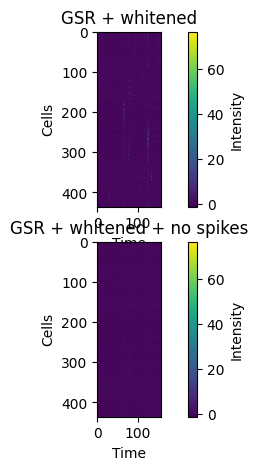

In [15]:
fig = plt.figure(figsize=(7,5))
gs = plt.GridSpec(2, 1, figure=fig)
ax = plt.subplot(gs[0,0])
imshow1 = ax.imshow(series_gsrw_after,vmin=series_gsrw_after.min(), vmax=series_gsrw_after.max())
plt.colorbar(imshow1, ax=ax, label='Intensity')
ax.set_ylabel('Cells')
ax.set_xlabel('Time')
ax.set_title('GSR + whitened')


ax2 = plt.subplot(gs[1,0])
imshow2 = ax2.imshow(series_gsrw_after_nospikes,vmin=series_gsrw_after.min(), vmax=series_gsrw_after.max())
plt.colorbar(imshow2, ax=ax2, label='Intensity')
ax2.set_ylabel('Cells')
ax2.set_xlabel('Time')
ax2.set_title('GSR + whitened + no spikes')

plt.savefig(f'network_inference_plots/{BOT}_gsrw_nospiking_series_comparison.png', dpi=300, bbox_inches='tight')

Infer functional connectivity

In [8]:
start_jvm("/Users/caitlingrasso/jidt/infodynamics.jar")
alpha = 0.001 # Uncorrected p-value
corrmat, mimat, corrmat_correct, mimat_correct, pmat = functional_connectivity(series_gsrw_after_nospikes, alpha=alpha)

In [9]:
# Save of FC matrix and processed time series
np.savetxt(f"network_inference_data/fc_matrices_synthetic/{BOT}_after_mimat_w_nospikes.csv", mimat_correct, delimiter=",")
np.savetxt(f"network_inference_data/series_synthetic/{BOT}_after_gsr_whitened_nospikes.csv", series_gsrw_after_nospikes, delimiter=",")

Display the actual FC matrix and synthetic FC matrix side by side

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_89805/4028902276.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


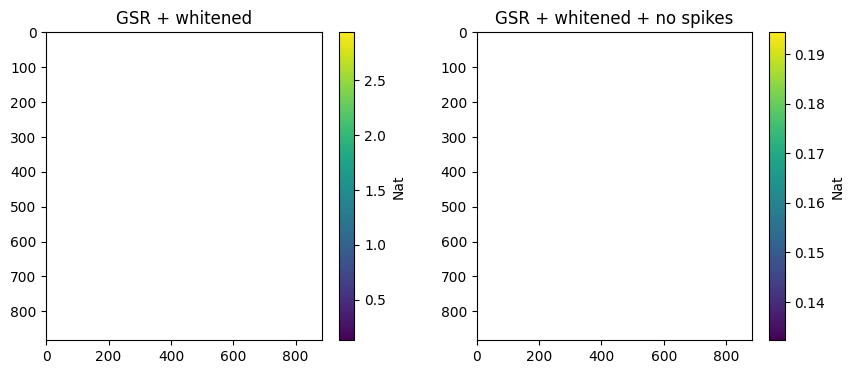

In [10]:
fig = plt.figure(figsize=(10,4))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.25)

fc_after[fc_after == 0] = np.nan
mimat_correct[mimat_correct == 0] = np.nan

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

imshow3 = ax1.imshow(fc_after,aspect='auto')
imshow4 = ax2.imshow(mimat_correct,aspect='auto')

plt.colorbar(imshow3, ax=ax1, label="Nat")
plt.colorbar(imshow4, ax=ax2, label="Nat")
plt.tight_layout()

ax1.set_title('GSR + whitened')
ax2.set_title('GSR + whitened + no spikes')

plt.savefig(f'network_inference_plots/{BOT}_gsrw_nospiking_FC_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Average across all cells (sanity check)

In [3]:
# Replace each value with the average of the column (i.e. the average across all cells)
series_gsrw_after_avg = np.tile(np.mean(series_gsrw_after,axis=0),reps=(series_gsrw_after.shape[0],1))


Text(0.5, 1.0, 'GSR + whitened + avg')

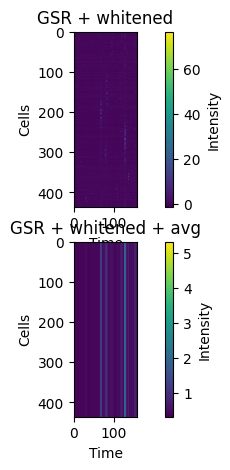

In [4]:
fig = plt.figure(figsize=(7,5))
gs = plt.GridSpec(2, 1, figure=fig)
ax = plt.subplot(gs[0,0])
imshow1 = ax.imshow(series_gsrw_after,vmin=series_gsrw_after.min(), vmax=series_gsrw_after.max())
plt.colorbar(imshow1, ax=ax, label='Intensity')
ax.set_ylabel('Cells')
ax.set_xlabel('Time')
ax.set_title('GSR + whitened')


ax2 = plt.subplot(gs[1,0])
# imshow2 = ax2.imshow(series_gsrw_after_avg,vmin=series_gsrw_after.min(), vmax=series_gsrw_after.max())
imshow2 = ax2.imshow(series_gsrw_after_avg)
plt.colorbar(imshow2, ax=ax2, label='Intensity')
ax2.set_ylabel('Cells')
ax2.set_xlabel('Time')
ax2.set_title('GSR + whitened + avg')


In [ ]:
start_jvm("/Users/caitlingrasso/jidt/infodynamics.jar")
alpha = 0.001 # Uncorrected p-value
corrmat, mimat, corrmat_correct, mimat_correct, pmat = functional_connectivity(series_gsrw_after_avg, alpha=alpha)

In [27]:
# Save of FC matrix and processed time series
np.savetxt(f"network_inference_data/fc_matrices_synthetic/{BOT}_after_mimat_w_avg.csv", mimat_correct, delimiter=",")
np.savetxt(f"network_inference_data/series_synthetic/{BOT}_after_gsr_whitened_avg.csv", series_gsrw_after_avg, delimiter=",")

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_89805/3717609593.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


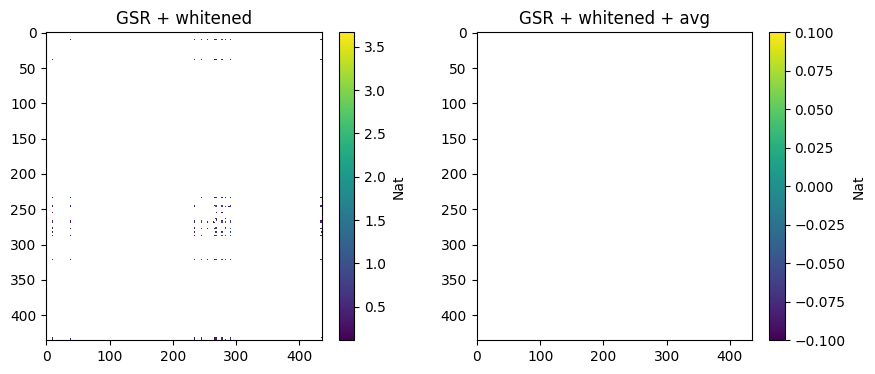

In [28]:
fig = plt.figure(figsize=(10,4))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.25)

fc_after[fc_after == 0] = np.nan
mimat_correct[mimat_correct == 0] = np.nan

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

imshow3 = ax1.imshow(fc_after,aspect='auto')
imshow4 = ax2.imshow(mimat_correct,aspect='auto')

plt.colorbar(imshow3, ax=ax1, label="Nat")
plt.colorbar(imshow4, ax=ax2, label="Nat")
plt.tight_layout()

ax1.set_title('GSR + whitened')
ax2.set_title('GSR + whitened + avg')

# plt.savefig(f'network_inference_plots/{BOT}_gsrw_nospiking_FC_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Diffusion model

(1162, 798)


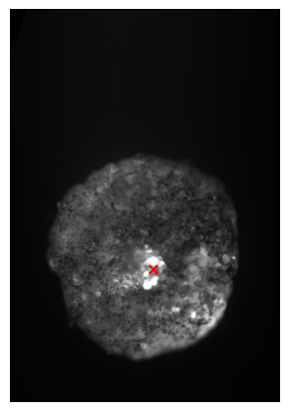

In [5]:
# Estimate the point of puncture from the after image

print(img_after.shape)
bot_01_after_point_of_puncture = [325,350] # estimate
bot_02_after_point_of_puncture = [425,770] # estimate

point_of_puncture = bot_02_after_point_of_puncture

# Visualize image
fig,ax = plt.subplots(layout="constrained", figsize=(3,4))
ax.imshow(img_after,cmap='gray')
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False, labeltop=False, which='both')
plt.scatter(point_of_puncture[0], point_of_puncture[1],marker='x',c='red')
plt.show()

In [6]:
dim = 501
circle_mask = np.zeros((dim, dim))

# Initial conditions - circle of radius r centred at (cx,cy) (mm)
r, c = 100, 250
r2 = r**2
for i in range(dim):
    for j in range(dim):
        p2 = (i-c)**2 + (j-c)**2
        if p2 < r2:
            circle_mask[i,j] = 255

In [47]:
cx = point_of_puncture[1]
cy = point_of_puncture[0]

# u0 = img_after.copy()
u0 = np.zeros(img_after.shape)
u0[cx-dim//2:cx+dim//2+1,cy-dim//2:cy+dim//2+1][circle_mask>0] = circle_mask[circle_mask>0]
u=u0.copy()

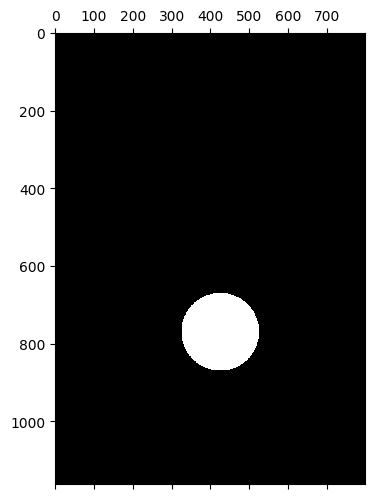

In [48]:
plt.matshow(u0,cmap='gray')
plt.show()

2D diffusion model

In [49]:
# https://scipython.com/book/chapter-7-matplotlib/examples/the-two-dimensional-diffusion-equation/
h = img_after.shape[1] * 500/310 # microns
w = img_after.shape[0] * 500/310 # microns
dx = dy = 0.1 # microns
D = 4 # in micron^2/s (pixels 310pixels/500microns, 1frame/5seconds)

In [50]:
dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))
nx, ny = int(w/dx), int(h/dy)
# dt = 1
print(dt,nx,ny)

0.0006250000000000001 18741 12870


In [51]:
def do_timestep(u0, u, mask):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )
    u[mask==0]=0 # can't diffuse past the boundaries of the organoid
    u0 = u.copy()
    return u0, u

0 0
5000 1
10000 2
15000 3


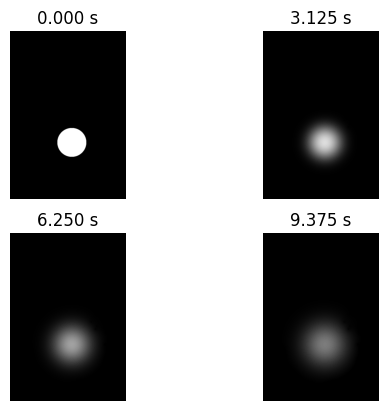

In [52]:
mask = img_after>17
nsteps=15001
mfig = [0, 5000,10000,15000]
# mfig = [0, 25, 50, 75]
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    if m in mfig:
        print(m,fignum)
        fignum += 1
        ax = fig.add_subplot(220+fignum)
        im = ax.imshow(u.copy(), cmap='gray', vmin=0,vmax=255)
        ax.set_axis_off()
        ax.set_title('{:.3f} s'.format(m*dt))

    u0, u = do_timestep(u0,u,mask)
fig.subplots_adjust(right=0.85)

In [39]:
# def get_neighbors(a):
#     # Moore neighborhood
#     b = np.pad(a, pad_width=1, mode='constant', constant_values=0)
#     neigh = np.concatenate((b[2:, 1:-1, None], b[:-2, 1:-1, None],
#                             b[1:-1, 2:, None], b[1:-1, :-2, None],
#                             b[:-2, :-2, None], b[:-2, 2:, None],
#                             b[2:, :-2, None], b[2:, 2:, None]), axis=2)
#     return neigh

In [110]:
# def diffuse_signal(u, u0, D):
#     # simulating gap junctions - signals diffuse to neighbors in all grids other than cell state
#     u = u0 * (1-D) + (D/8) * np.sum(get_neighbors(u0), axis=2) # conservation of signal
#     u0=u.copy()

#     return u,u0

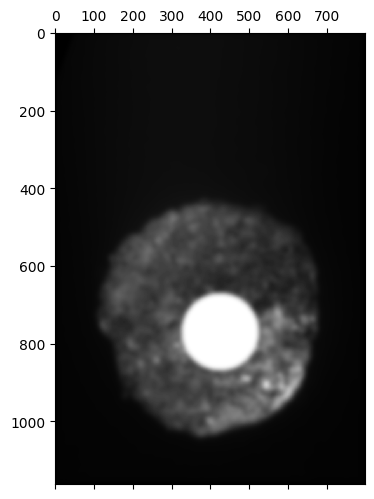

In [112]:
# D = 0.5
# for i in range(100):
#     u,u0 = diffuse_signal(u,u0,D)

# plt.matshow(u,cmap='gray')

In [ ]:
# Erode the image from the center

# mask = img_after>17
# plt.matshow(mask, cmap='gray')
# plt.show()

# flash = np.zeros(mask.shape)
# flash[mask==1] = 255

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
# flash_open = cv2.dilate(flash, kernel, iterations=1)

# kernel = np.ones((5, 5), np.uint8) 
# flash_erosion = cv2.erode(flash_open, kernel, iterations=50) 


# plt.matshow(flash_erosion,cmap='gray')
# plt.show()

# u0 = img_after.copy()
# u = u0.copy() 
# u0[flash_erosion>0] = flash_erosion[flash_erosion>0]

# plt.matshow(u0, cmap='gray')
# plt.show()